# Assignment 6: Modeling Collective Behavior in Ants

### Assignment description:

In this assignment you will translate the simple ordinary differential equation (ODE) model as described in the Pratt lecture into an agent-based model. You will explore the implementation of agent based models in Python by using the ``Mesa`` package and compare your results to those from the ODE model.

### Assignment goals:

1. Learn how to convert an ODE model to an agent based model.
2. Demonstrate the ability to create an agent based model using the `Mesa` package

### Assignment question overview:

1. Write the Ant agent class to complete the agent based model. [Question 1](#question1)


Please run the below code to install the appropriate libraries.

In [5]:

import time
import numpy as np
import importlib
import sys
import pandas as pd
import random
from patsy import highlevel
!pip install mesa
!pip install brewer2mpl
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import math
import sys
from ggplot import *
from ggplot import ggplot


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


## Agent-based Modeling

Agent-based models are used to simulate many actors or "agents" and their actions and interactions. These models differ from ODE models in that rather than averaging the behaviors across actors in the model, each actor is a distinct part of the model and acts accordingly to a specified set of rules. These actors respond to both the environment and other actors within the system. Often, these models are used to simulate epidemics in which the actors represent humans and the interaction between sick individuals and healthy individuals allows for the epidemic to spread. In this assignment, the actors will be ants and rather than becoming infected with a disease, these ants will be influenced by recruitment via tandem running. 

## Forager Behavior Problem and Model

### Forager Experiment

As described in the "Collective cognition in ant societies" lecture by Dr. Stephen Pratt, a simple feeder experiment can be used to demonstrate how ants collectively select a food source. In this experiment, as shown in Figure 1, two feeders are placed equidistant from a colony nest. Then, the exploration and tandem-running behaviors of ants can be observed. Ants explore the presence of the two feeders and perform tandem runs to recruit ants to the stronger feeder. Please refer to Dr. Pratt's lecture for variations and more detail on this experiment. 
<a id='forager_model'></a>
### Forager Model (ODE)

As shown in Figure 2, Pratt defines a model in which the ants can be in one of three states: (1) uncommitted to a feeder; (2) committed to feeder A; and (3) committed to feeder B. In this model, every ant must be in one of these three states at any time step. To describe how ants transition between states, Pratt introduces $\beta, \alpha, $ and $\lambda$ parameters. The parameters $\alpha_A$ and $\alpha_B$ describe the rate at which the uncommitted ants discover feeder A and feeder B respectively. In addition to independent discovery, ants can also be recruited by interacting with those ants who have committed to either feeder. This recruitment happens at the rate $\beta_A$ for feeder A and $\beta_B$ for feeder B. Finally, ants are not necessarily committed to a single feeder for the duration of the experiment and may return to the uncommitted state at an attrition rate of $\lambda_A$ for feeder A and $\lambda_B$ for feeder B.

<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="Forwarding" src="images/ant_feeder.png" width="260">
    <br>
    <em style="color: grey">Figure 1: Ant feeder experiment</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="images/transition_diagram.png" width="650">
    <br>
    <em style="color: grey">Figure 2: State transition diagram for forager behavior</em>
  </p> 
</td>
</tr></table>

*Image sources: Dr. Stephen Pratt*


## Model Implementation 

In this assignment we will use the ``Mesa`` Python package to implement our agent-based model. This assignment will be largely based around the introductory tutorial provided by ``Mesa`` and can be found [here](https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html) as well as an implementation for pheromone laying ants by Mark Goadrich  which can be found on GitHub [here](https://github.com/mgoadric/ants-mesa).  

### From ODE to Agent-based

A ``Mesa`` simulation consists of two main classes, one for the model and the other for the agents. Each agent contains information about the state of the individual as well as how one instance of an agent may interact with another. The model class contains information such as the general parameters, the grid the agents move on, and keeps track of the agents in their current state. 

The first step in converting an ODE model into an agent-based model is to establish a environment for the agents to exist in. The grid below shows the environment we will be using for this assignment. The grid is $50 \times 50$ in dimension and the origin is located at the bottom left. The nest is at the location $(25,5)$ and the strong and weak feeder are at locations $(10, 40)$ and $(40, 40)$ respectively. The class that holds this model is given in the model section [here](#model).

<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="Forwarding" src="images/grid_feeders.png" width="500">
    <br>
    <em style="color: grey">Figure 3: Environment for agent-based model</em>
  </p> 
</td>
</tr></table>


## Agent Classes

Now that we have established some background on where exactly these ants will be searching for food, lets take a look at our four agent classes that comprise our model. 

### Environment Agent

The `Environment` agents will work as a place holder to give each cell on the grid a unique identifier and position. This class is given to you below. In the model class, one ``Environment`` agent will be placed on each cell. These agents do not move or have any other properties. However, they will come in handy when the ant needs to look at which cells are available to move to.

In [6]:
class Environment(Agent):

    def __init__(self, unique_id, pos, model):
        super().__init__(unique_id, model)
        self.pos = pos

    def get_pos(self):
        return self.pos



#The environment agent is placed on each cell as a place holder. 

### Nest Agent

The `Nest` agent records the location of the nest. The nest will be placed on the grid at location $(25,5)$. This agent class is given to you below.

In [7]:
class Nest(Agent):
    '''
    The ant nest.
    '''
    def __init__(self, unique_id, pos, model):
        '''
        Records the unique_id with the super, and saves the pos.
        '''
        super().__init__(unique_id, model)
        self.pos = pos

### Food Agent

The food agents represent the two feeders on the map. Each agent has a unique ID, position and amount of food. The constructor initializes the amount of food to 0 and the model class adds 100 units of food to each feeder. The `add(amount)` method adds a specified amount of food to the feeder. The `eaten()` method is used by the ants to consume one food unit from the feeder. The `any_food()` class returns a boolean indicating if there is food remaining in the feeder.

In [8]:
class Food(Agent):
    '''
    A food cache for the ants, recording how much food is available.
    '''
    def __init__(self, unique_id, model):
        '''
        Records the unique_id with the super.
        Initializes the food amount to 0.
        '''
        super().__init__(unique_id, model)
        self.amount = 0
        
    def add(self, amount):
        '''
        Add the amount to the food amount
        '''
        self.amount += amount
        
    def eaten(self):
        '''
        Removes one food if there are any available.
        '''
        if self.any_food():
            self.amount -= 1
    
    def any_food(self):
        '''
        Returns a bool to show if there is any food available
        '''
        return self.amount > 0 

### Ant Agent

The final agent class defines the primary agents of the model, that is they will be moving and interacting with the other agents. As shown in the ODE model, each ants has three states as follows:

- Uncommitted,
- Committed to Feeder A,
- and Committed to Feeder B.

Note that one of the main assumptions of this model, and the ODE model, is that all ants are explorers and have the ability to recruit other ants.

The ant class will consist of how ever many methods you decide you need to complete the requirements listed under [Question 1](#question1). You are expected to write these methods as detailed below.


<a id='question1'></a>
# Question 1:

This is the only question of the assignment, but it may take some time to complete accurately. It will require you to write the complete `Ant` agent class. It is strongly recommended that you refer to the pheromone laying ants model by Mark Goadrich  which can be found on GitHub [here](https://github.com/mgoadric/ants-mesa). This will provide insight about how the `Mesa` package can be applied to this problem.

### Constructor

The constructor will meet the following criteria:

- The starting position of each ant is the nest location;
- Each ant is initialized in the "UNCOMMITTED" state;
- Each ant is initialized with its tandem running flag equal to 0.

### `step()` Method

Since the ants will be moving with the help of a scheduler, this method will determine how each ant moves on each step depending on its current state and its tandem running flag. Figure 7 (shown below) gives a flow chart describing how the ant will move depending on its state. The red boxes with rounded edges denote states, the diamond shapes denote conditionals, and the black boxes with vertical lines denote actions.

All ants begin in the uncommitted state. If an ant is in UNCOMMITTED, it first checks if it is currently at a food source. If it is at a food source it commits to this food source with probability $\alpha_A$ or $\alpha_B$ depending on which feeder it is at. If it is not currently at a food source, or cannot commit due to the alpha parameters, it moves one cell in a random direction. In the ant commits to a food source, its state changes to either "COMMITTED A" or "COMMITTED B" depending on which feeder it is currently at. This sub-process is shown in the flow chart in Figure 4. 

<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="Forwarding" src="images/flow_chart_pt1.png" width="500">
    <br>
    <em style="color: grey">Figure 4: Flow chart for ant movement from initial state to committed state</em>
  </p> 
</td>
</tr></table>


Once an ant commits to a food source, it also attempts to uncommit with probability $\lambda_A$ or $\lambda_B$ for feeder A and feeder B respectively. If it stays committed, then the ant's state remains committed as before.

If the ant is currently tandem running and not at a food source, it will move in the direction of the cell closest to the food source ("food move" in the figure). If the ant is currently tandem running and already at a food source it will eat the food, stop tandem running, and return to the committed state. This subprocess is shown in Figure 5 for only feeder A. The feeder B process is identical and shown in Figure 7.


<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="Forwarding" src="images/flow_chart_pt2.png" width="500">
    <br>
    <em style="color: grey">Figure 5: Flow chart for ant movement once it is committed to feeder A and tandem running.</em>
  </p> 
</td>
</tr></table>


Next, if the ant is committed to a food source but not tandem running, it will look for a recruit. An ant can recruit another ant if they share the same cell and the potential recruit is in the uncommitted state. If an ant finds a recruit at the current step it will recruit the ant with probability $\beta_A$ or $\beta_B$ for feeder A or feeder B, depending on which feeder it is committed to. To complete a successful recruitment, the ant will commit the recruit to its feeder and set both itself and the recruit's tandem running flag to true. Figure 6 shows this process for feeder A, the process is the same for feeder B and can be seen in figure 7.


<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="Forwarding" src="images/flow_chart_pt3.png" width="400">
    <br>
    <em style="color: grey">Figure 6: Flow chart for ant movement once committed to feeder A and not tandem running.</em>
  </p> 
</td>
</tr></table>

Figure 7 shows all of the subprocesses together to create the entire `step()` method. 

<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="Forwarding" src="images/flow_chart.png" width="800">
    <br>
    <em style="color: grey">Figure 7: Flow chart for ant movement and states</em>
  </p> 
</td>
</tr></table>


### `get_distance(pos_1, pos_2)` Function

This helper function is given to you, feel free to use it (or don't) in your solution. When moving towards a food source, you will need to minimize the distance across all neighboring cells and the target food source.

In [27]:
# from sugarscape_cg
def get_distance(pos_1, pos_2):
    """ 
    Get the distance between two point
    Args:
        pos_1, pos_2: Coordinate tuples for both points.
    """
    x1, y1 = pos_1
    x2, y2 = pos_2
    dx = x1 - x2
    dy = y1 - y2
    return math.sqrt(dx ** 2 + dy ** 2)

In [38]:
class Ant(Agent):
    '''
    The ants wander randomly around the world in search of food. 
    If the ants find food, the commit to the feeder and attempt to recruit other ants.
    '''
    
    # your code here
    def __init__(self, unique_id, nest, model):
        super().__init__(unique_id, model)
        self.state = "UNCOMMITTED"
        self.tandem_running = False
        
    def get_friendly_ants(self):
        cell_agents = self.model.grid.get_cell_list_contents(self.pos)
        friendly_ants = [agent for agent in cell_agents if isinstance(agent, Ant) and agent.state == "UNCOMMITTED"]
        return friendly_ants
                                       
    def get_food_at_location(self):
        agents = self.model.grid.get_cell_list_contents([self.pos])
        for agent in agents:
            if isinstance(agent, Food):
                return agent
        return None
    
    def random_move(self):
        next_moves = self.model.grid.get_neighborhood(self.pos, moore = True, include_center = False)
        next_move = random.choice(next_moves)
        self.model.grid.move_agent(self, next_move)
        
    def move_towards(self, agent):
        neighbors = [n.get_pos() for n in self.model.grid.get_neighbors(self.pos, moore = True, include_center = False) if type(n) is Environment]

        min_dist = min([get_distance(agent.pos, pos) for pos in neighbors])
        final_candidates = [pos for pos in neighbors if get_distance(agent.pos, pos) == min_dist]
#         self.random.shuffle(final_candidates)
        self.model.grid.move_agent(self, final_candidates[0])

    def step(self):
        if self.state == "UNCOMMITTED":
            alpha = None
            commit_type = ""
            food = self.get_food_at_location()
            if food:
                food.eaten()
                if food == self.model.foods[0]:
                    alpha = self.model.alpha_A
                    commit_type = "A"
                elif food == self.model.foods[1]:
                    alpha = self.model.alpha_B
                    commit_type = "B"
                if random.random() < alpha: 
                    self.state = "COMMITTED " + commit_type
            else:
                self.random_move()
                
        elif self.state == "COMMITTED A":
            if random.random() < self.model.lambda_A:
                self.state = "UNCOMMITTED"
            else:
                if self.tandem_running == False:
                    ants = self.get_friendly_ants()
                    
                    for ant in ants:
                        if random.random() < self.model.beta_A:
                            ant.state = "COMMITTED A"
                            ant.tandem_running = True
                            self.tandem_running = True
                            break
                    if self.tandem_running == False:
                        self.random_move()
                        
                elif self.tandem_running == True:
                    food = self.get_food_at_location()
                    if food:
                        food.eaten()
                        self.tandem_running = False
                    else:
                        food_A = self.model.foods[0] 
                        self.move_towards(food_A)
                    
        elif self.state == "COMMITTED B":
            
            if random.random() < self.model.lambda_B:
                self.state = "UNCOMMITTED"
            else:
                if self.tandem_running == False:
                    ants = self.get_friendly_ants()
                    
                    for ant in ants:
                        if random.random() < self.model.beta_B:
                            ant.state = "COMMITTED B"
                            ant.tandem_running = True
                            self.tandem_running = True
                            break
                    if self.tandem_running == False:
                        self.random_move()
                        
                elif self.tandem_running == True:
                    food = self.get_food_at_location()
                    if food:
                        food.eaten()
                        self.tandem_running = False
                    else:
                        food_B = self.model.foods[1] 
                        self.move_towards(food_B)
        

                                   
#         next_moves = self.model.grid.get_neighborhood(self.pos, moore = True, include_center = False)
#         next_moves_distances = [get_distance(move, agent.pos) for move in next_moves] 
#         minimum_distance_index = 0
#         for index, distance in enumerate(next_moves_distances):
#             if distance < next_moves_distances[minimum_distance_index]:
#                 minimum_distance_index = index
#         self.model.grid.move_agent(self, next_moves[minimum_distance_index])    

        

<a id='model'></a>
## Model Class

The ``Model`` class defines a grid and it keeps track of the agents through time. On each time step, the ants who are able to recruit new ants will do so depending on where they are in space and if another ant is available to be recruited. The ``DataCollector`` class is used to keep track of the agents. In particular, the data collector records the amount of food in each feeder on every time step.

Additionally, the grid is an instance of the ``MultiGrid`` class. We opt to use the ``MultiGrid`` class because it allows multiple agents to occupy a single cell simultaneously. If ants were not allowed to come into contact with each other, there would be no recruitment. The definition of the model class and the relevant parameter values are set for you. The simulation ends when one feeder is completely depleted. In this case, we expect feeder A to be depleted much faster than feeder B.

### Parameter Values

The parameter values come from the article "Linear recruitment leads to allocation and flexibility in collective foraging by ants" as discussed in Dr. Pratt's lecture. These values were a result of fitting the ODE model to real data. Note that in the article, one time step was equal to one minute whereas, in our simulation one time step is equal to one second. For this reason, the parameter values were all multiplied by 60. Additionally, our simulation will have 100 ants.

In [39]:
class AntModel(Model):
    '''A model for ant foraging.'''
    
    def __init__(self, N=100, width=50, height=50, alpha_A = 0.0125*60, alpha_B = 0.0125*60, 
               beta_A = 0.015*60, beta_B = 0.006*60, lambda_A = 0.009, lambda_B = 0.038):
        
        
        super().__init__()
        ##assign parameters to local variables
        self.num_agents = N
        self.alpha_A = alpha_A
        self.alpha_B = alpha_B
        self.beta_A = beta_A
        self.beta_B = beta_B
        self.lambda_A = lambda_A
        self.lambda_B = lambda_B
        
        ##Set up of the grid and schedule:
        
        # Use SimultaneousActivation which simulates all the cells
        # computing their next state simultaneously.  This needs to
        # be done because each cell's next state depends on the current
        # state of all its neighbors -- before they've changed.
        self.schedule =  SimultaneousActivation(self)
        
        ##define 2-d grid
        self.grid = MultiGrid(width, height, False)
        
        ##define starting positions for the nest and food locations
        nest_loc = (25, 5)
        self.food_locs = ((10, 40), (40, 40))
        
        self.nest = Nest(self.next_id(), nest_loc, self)
        self.foods = []
        self.grid.place_agent(self.nest, nest_loc)
        self.schedule.add(self.nest)
        
        ##Add in the ants
        ##create agents
        for i in range(self.num_agents):
            ant = Ant(self.next_id(), self.nest, self) ##instantiate agent i
            self.grid.place_agent(ant, self.nest.pos) ##place ant in nest
            self.schedule.add(ant) ##add ant to schedule
            
        ##add the food locations
        for loc in self.food_locs:
            food = Food(self.next_id(), self) ##instantiate food 
            food.add(100) ##give food value
            self.grid.place_agent(food, loc) ##place food source on grid
            self.schedule.add(food) ##add food to schedule
            self.foods.append(food) ##add food to local list
            
            
        ##add the environment cells
        for (contents, x, y) in self.grid.coord_iter():
            cell = Environment(self.next_id(), (x,y), self)
            self.grid.place_agent(cell, (x,y))
            self.schedule.add(cell)
        
        self.running = True
        
        ##Record the data 
        self.dc = DataCollector({"Feeder A:": lambda m: self.foods[0].amount,
                               "Feeder B:": lambda m: self.foods[1].amount})
        
    def step(self):
        '''Have the scheduler advance each cell by one step'''
        
        ##one step
        self.schedule.step()
        
        ##collect data
        self.dc.collect(self)
        
        ##stop when all of the food in a feeder is collected
        if not self.foods[0].any_food() or not self.foods[1].any_food():
            self.running = False

## Running the Model

Running the model is straightforward. First, we create an instance of the model class, then we use the `run_model()` method to start the scheduler, and finally, we record the results into a data frame. This is given to you below.

In [40]:
ants = AntModel() #create an instance of the model
ants.run_model() #run the model
results = ants.dc.get_model_vars_dataframe() #store the results

## Visualizing the Results

To visualize the results, we will first print the data frame to get an idea of the number of iterations needed to complete the simulation and to see the two feeders at the end of a run. Then, we will use the data frame to plot the amount of food in each feeder over time. 

Ideally, you should observe that feeder A is consumed much faster than feeder B. In this section, your results will be graded. Due to the stochastic nature of the simulation, your run must be within two standard deviations of a distribution generated over 100 runs.

The code to plot the results is given below and the test cases are hidden.

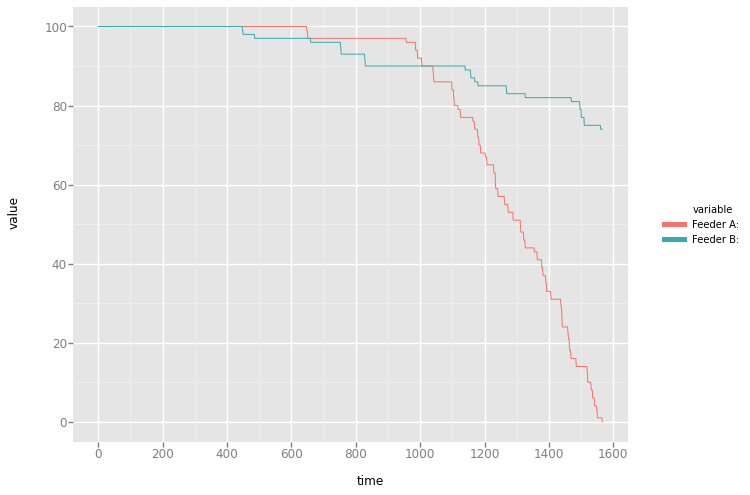

<ggplot: (8728677975957)>

In [41]:
results["time"] = np.linspace(0, len(results) - 1, len(results))
resultsmelt = pd.melt(results, id_vars=["time"], value_vars=["Feeder A:","Feeder B:"])
ggplot(resultsmelt, aes(x="time", y="value", color="variable")) \
+ geom_line()

In [42]:
'''
THIS IS A TEST CELL, RUN ME!
'''



'\nTHIS IS A TEST CELL, RUN ME!\n'